## A study on Reuters-21578 Dataset

https://archive.ics.uci.edu/ml/machine-learning-databases/reuters21578-mld/reuters21578.tar.gz

In [211]:
#For live lossplot while training NN
from IPython.display import clear_output
from keras.callbacks import Callback
from livelossplot.keras import PlotLossesCallback

import random
import glob
import re
import html
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

from gensim.utils import simple_preprocess, lemmatize
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, LSTM, Input
from keras.layers.normalization import BatchNormalization

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers, metrics

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [3]:
random.seed(1000)

data_folder = './reuters/'

sgml_files = glob.glob(data_folder + 'reut*.sgm')

category_files = {
    'to_': ('topics', 'all-topics-strings.lc.txt'),
    'pl_': ('places', 'all-places-strings.lc.txt'),
    'pe_': ('people', 'all-people-strings.lc.txt'),
    'or_': ('organizations', 'all-orgs-strings.lc.txt'),
    'ex_': ('exchanges', 'all-exchanges-strings.lc.txt')
}

# Word2Vec number of features
num_features = 300
# Limit each newsline to a fixed number of words
document_max_num_words = 100

In [212]:
# Create category dataframe

# Read all categories
category_data = []

for category_prefix in category_files.keys():
    with open(data_folder + category_files[category_prefix][1], 'r') as file:
        for category in file.readlines():
            category_data.append([category_prefix + category.strip().lower(), 
                                  category_files[category_prefix][0], 0])

# Create category dataframe
news_categories = pd.DataFrame(data=category_data, columns=['name', 'type', 'newslines'])
news_categories[:5]

,name,type,newslines
0,to_acq,topics,0
1,to_alum,topics,0
2,to_austdlr,topics,0
3,to_austral,topics,0
4,to_barley,topics,0


In [5]:
#Preprocessing text
def strip_tags(text):
    return re.sub('<[^<]+?>', '', text).strip()

#Category List
def add_cat(categories, cat_type):
    for cat in categories:
        document_categories.append(cat_type + cat.text)

In [227]:
#Load data from sgm files to pandas.

doc_list = []
for sgm_file in sgml_files:
    with open(sgm_file, 'r', errors='replace') as file:
        content = BeautifulSoup(file.read().lower())

    for newsline in content('reuters'):
        document = {}
        document_categories = []
        document_id = newsline['newid']

        document_body = strip_tags(newsline('text')[0].text).replace('reuter', ' ').replace('reuters', ' ').replace('\n', ' ')
        #document_body = html.unescape(document_body)
        document_body = simple_preprocess(document_body)
        #document_body = [word.decode('utf-8').split('/')[0] for word in gensim.utils.lemmatize(document_body)]
        
        document_categories = []
        add_cat(newsline.topics, 'to_')
        add_cat(newsline.places, 'pl_')
        add_cat(newsline.people, 'pe_')
        add_cat(newsline.orgs, 'or_')
        add_cat(newsline.exchanges, 'ex_')

        document['id'] = document_id
        document['document_body'] = document_body
        for topic in news_categories.loc[news_categories['type'] == 'topics', 'name']:
            document[topic] = 1. if topic in document_categories else 0.
        doc_list.append(document)
        for category in document_categories:
            news_categories.loc[news_categories['name']==category, 'newslines'] += 1.0
    #print(sgm_file)


In [213]:
doc_topic = pd.DataFrame(doc_list).set_index('id')
del doc_list

#### A skip-gram word2vec model with 300 features. Corpus is the entire words available in the dataset.


In [214]:
w2v_model = Word2Vec(
        doc_topic['document_body'],
        size=num_features,
        window=10,
        min_count=2,
        workers=10)

In [215]:
w2v_model.train(doc_topic['document_body'], total_examples=len(doc_topic['document_body']), epochs=50)

(100943583, 128504300)

#### Some Semantic similarity checks on our word2vec model.

##### Set of most similiar vectors with v(iraq) + v(iran) - v(baghdad) contains 'tehran', 'karbala' etc

In [216]:
w2v_model.wv.most_similar(positive=['iraq', 'iran'], negative=['baghdad'])

[('hostilities', 0.31092846393585205),
 ('redman', 0.3050450086593628),
 ('arms', 0.2994941771030426),
 ('tehran', 0.298763632774353),
 ('iranian', 0.2860909700393677),
 ('arabia', 0.28553706407546997),
 ('karbala', 0.28208422660827637),
 ('kuwait', 0.28117358684539795),
 ('offensive', 0.2797704339027405),
 ('nigeria', 0.27610278129577637)]

##### Set of most similiar vectors with v(french) + v(english) - v(france) contains 'languages' 

In [220]:
w2v_model.wv.most_similar(positive=['french', 'english'], negative=['france', 'england'])

[('language', 0.2767493426799774),
 ('teacher', 0.26954251527786255),
 ('collectively', 0.2528124749660492),
 ('amnesty', 0.23045136034488678),
 ('zeitung', 0.22088424861431122),
 ('mirabel', 0.21827362477779388),
 ('boersen', 0.21655094623565674),
 ('subsidy', 0.21044550836086273),
 ('von', 0.20955589413642883),
 ('quoting', 0.209518164396286)]

##### Set of most similiar vectors with v(actress) + v(woman) - v(man) contains 'actress'

In [218]:
w2v_model.wv.most_similar(positive=['actor', 'woman'], negative=['man'])

[('actress', 0.348752498626709),
 ('screenplay', 0.2872823476791382),
 ('performs', 0.2742621898651123),
 ('extorting', 0.27390730381011963),
 ('tsuda', 0.26588401198387146),
 ('milestone', 0.26565444469451904),
 ('oscar', 0.2527948319911957),
 ('pompano', 0.25246545672416687),
 ('wachovia', 0.24646367132663727),
 ('tuskaloosa', 0.23814301192760468)]

In [ ]:
#w2v_model.wv.save('reuters.word2vec')
#w2v_model = KeyedVectors.load('reuters.word2vec', mmap='r')

In [253]:
topics = news_categories[news_categories['type']=='topics'].sort_values('newslines', ascending=False)
sparse_topics = list(topics['name'][news_categories['newslines']<20])
sparse_topics
#removing all topic features that have less than 20 documents (ie very low predictive potential)
for topic in sparse_topics:
    del doc_topic[topic]          

#removing all data points with no category once sparse_topics have been removed
doc_topic = doc_topic[doc_topic.sum(axis=1)>=1.0]

In [269]:
x_ax = topics[0:10].name.values
y_ax = topics[0:10].newslines.values

##### Top 10 Topics and their count

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

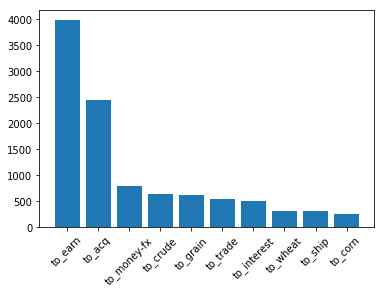

In [274]:
plt.bar(x_ax, y_ax)
plt.xticks(rotation=45)
#plt.show()

In [241]:
num_categories = doc_topic.shape[1] - 1
number_of_documents = doc_topic.shape[0]
number_of_documents

21578

##### Functions for vectorising and padding documents


In [134]:
def return_w2v(word):
    try:
        return w2v_model.wv[word] 
    except:
        return np.array([0.0]*num_features)
        

def vectorize_doc(doc):
    list_ = [return_w2v(word)  for word in doc]
    arr_ = list_ + [[0.0]*num_features]*(document_max_num_words-len(list_))
    return np.array(arr_)
    

In [47]:
X = np.stack(doc_topic['document_body'].apply(lambda x: x[:100]).apply(vectorize_doc).values)
Y = doc_topic.iloc[:,1:].values

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)
del X

##### Model Definition. Simple Sequential Model.


In [49]:
model = Sequential()
model.add(LSTM(int(document_max_num_words*1.5), input_shape=(document_max_num_words, num_features)))
model.add(Dropout(0.2))
#model.add(BatchNormalization())
model.add(Dense(num_categories))
model.add(Activation('sigmoid'))
adam = optimizers.adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


##### Model accuracy and log seems to converge at around 4th epoch. Since this is a multilabel classification 'accuracy' is not a good metric.

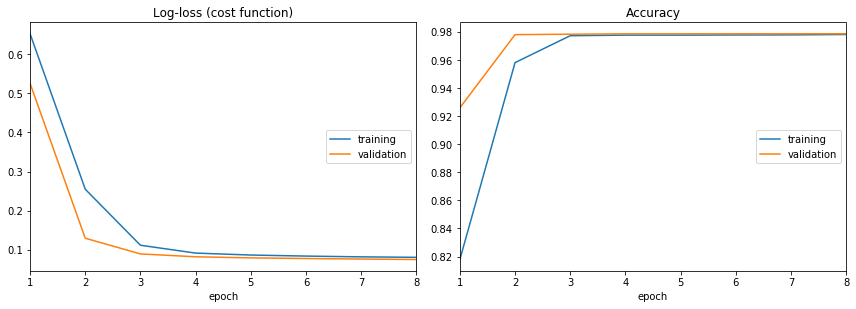

Log-loss (cost function):
training   (min:    0.080, max:    0.652, cur:    0.080)
validation (min:    0.075, max:    0.525, cur:    0.075)

Accuracy:
training   (min:    0.818, max:    0.978, cur:    0.978)
validation (min:    0.926, max:    0.979, cur:    0.979)


In [50]:
model.fit(X_train, Y_train, batch_size=128, epochs=4, validation_data=(X_test, Y_test), \
          callbacks=[PlotLossesCallback()], verbose=0)


In [51]:
score, acc = model.evaluate(X_test, Y_test, batch_size=128)
score, acc

3384/3384 [==============================] - 3s 1000us/step


(0.0748821731225255, 0.9785108669147987)

##### A comparison between the actual topics and top-5 predicted topics of one data-point.

In [208]:
validation_set =  doc_topic[3000:3001]
validation_X = validation_set['document_body']
validation_Y_observed = [x for x in validation_set.iloc[:,1:].columns if validation_set[x].values == 1]
validation_Y_predicted = pd.DataFrame([dict(zip(validation_set.iloc[:,1:].columns, \
                                                model.predict(np.array([vectorize_doc(validation_X[0][:100])]))[0]))])

##### Both the predicted and actual topics seems to agree. TODO: Check top-5 accuracy.

In [229]:
#validation_Y_predicted.idxmax(axis=1)
validation_Y_predicted.melt().sort_values('value', ascending=False)[:5]

,variable,value
13,to_earn,0.387894
0,to_acq,0.190700
29,to_money-fx,0.055718
18,to_grain,0.039848
11,to_crude,0.039223


In [230]:
validation_Y_observed

['to_earn']